# 01 - Polynomial Linear Regression (One Variable)
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

In [1]:
# First, some necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

%matplotlib inline
np.random.seed(42)

## The Data
We're mainly working with the Boston Housing dataset (Harrison & Rubinfield, 1993) for this problem. Scikit-learn has a convience function that loads the dataset so we'll use that.

In [2]:
d = load_boston()
print(d.DESCR) # Print the dataset description

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

We can extract the data like so.

In [3]:
X, y = d.data, d.target

And get the shapes.

Notice that we have a matrix of examples $X \in \mathbb{R}^{m \times d}$ and a vector of targets $y \in \mathbb{R}^m$ where $m$ is the number of training examples and $d$ is the "dimensionality" or the number of features.

In [4]:
print(X.shape, y.shape)

(506, 13) (506,)


For now, we're only interested in the property tax feature of the dataset, which is in index 8. We'll take that out. Since the resulting numpy array is a 1d vector, we'll add a new axis (new dimension).

In [5]:
x = X[:, 9]
print(x.shape, y.shape)

# Add new dimension
x = x[..., np.newaxis]
print(x.shape)

(506,) (506,)
(506, 1)


We'll write a convenience function to plot our data.

In [6]:
def plot_dist(X, y):
    data = np.append(X[:, 0][..., np.newaxis], y[..., np.newaxis], axis=1)
    data = data[data[:, 0].argsort()]
    plt.scatter(data[:, 0], data[:, 1], c='r')

And let's check our data.

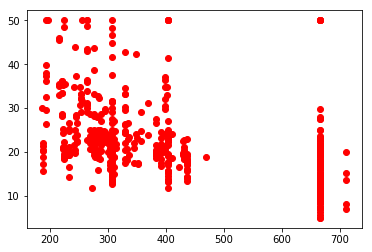

In [7]:
plot_dist(x, y)

## Linear Regression
Now we'll use a linear regression model to solve our task.

Recall our hypothesis for linear regression:

\begin{align}
h_{\theta}(x) = \theta_0x_0 + \theta_1x_1 + ... + \theta_nx_n
\end{align}

Which we can simply write as a summation:

\begin{align}
h_{\theta}(x) = \sum_{i=0}^{m}{\theta_{i}x_{i}}
\end{align}

Which can be simplified in vector notation:

\begin{align}
h_{\theta}(x) = X \theta
\end{align}

Given $X\in\mathbb{R}^{m\times d}$ and our theta parameter vector $\theta\in\mathbb{R}^{d\times 1}$, our ```model``` function will output a 2d array of predictions (specifically $\hat{y}\in\mathbb{R}^{m\times 1}$). Since our actual target vector is a 1d array ($y\in\mathbb{R}^m$), we'll index the first column on our output to reduce the dimensions.

In [8]:
def model(X, theta):
    return X.dot(theta)[:, 0]

We'll have to first add a bias term to our data manually, represented by an array of ones.

In [9]:
bias = np.ones([x.shape[0], 1], dtype=np.int32)
print(bias.shape, x.shape)

(506, 1) (506, 1)


We append this to the data.

In [10]:
x = np.append(x, bias, axis=1)

To get the shape:

In [11]:
print(x.shape)

(506, 2)


Our feature matrix now looks like this.

In [12]:
x

array([[296.,   1.],
       [242.,   1.],
       [242.,   1.],
       ...,
       [273.,   1.],
       [273.,   1.],
       [273.,   1.]])

We'll randomly initialize our theta vector $\theta\in\mathbb{R}^{d\times 1}$.

In [13]:
features = x.shape[1]
print("Number of features: {}".format(features))

theta = np.random.rand(features, 1)
print(theta)

Number of features: 2
[[0.37454012]
 [0.95071431]]


And get our initial predictions.

In [14]:
yhat = model(x, theta)

Verify the shapes.

In [15]:
print(yhat.shape, y.shape)

(506,) (506,)


Next, we'll need a measure of error.

Recall our Mean Squared Error (MSE) loss function:

\begin{align}
J(\theta) = \frac{1}{2m}\sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2
\end{align}

Which in vector notation is simply:

\begin{align}
J(\theta) = \frac{1}{2m}(X\theta - y)^T(X\theta - y)
\end{align}

In [16]:
def loss_function(yhat, y):
    m = y.size
    J = 1 / (2 * m) * np.sum(np.square(yhat - y))
    return J

Let's test it.

In [17]:
loss_function(yhat, y)

10924.413868645808

Now we code up gradient descent. The update rule for gradient descent is:

\begin{align}
\theta := \theta - \alpha \frac{\partial}{\partial \theta}J(\theta)
\end{align}

Computing for the partial derivative yields this update rule:

\begin{align}
\theta := \theta - \alpha \frac{1}{m}\sum^{m}_{i = 0}(h_{\theta}(x^{(i)})-y^{(i)})\cdot x^{(i)}
\end{align}

Or in vector notation:

\begin{align}
\theta := \theta - \alpha \frac{1}{m} X^{T}(\hat{y}-y)
\end{align}


Do remember that the update rule has to be applied for all theta parameters consecutively. Since we have a bias feature, we have two theta parameters.

First, we code up the derivative of our loss function for convenience.

In [18]:
def loss_derivative(X, y, theta):
    yhat = model(X, theta)
    diff = (yhat - y)[..., np.newaxis]
    return X.T.dot(diff)

We can test it.

In [19]:
loss_derivative(x, y, theta)

array([[32865637.63732845],
       [   66447.46470911]])

Then we code up gradient descent itself.

In [20]:
def gradient_descent(X, y, theta, alpha=0.01):
    m = y.size
    yhat = model(X, theta)
    loss_p = loss_derivative(X, y, theta)
    new_theta = theta - alpha * (1 / m) * loss_p
    return new_theta

## Training
Next up, we train our model using gradient descent and observe how the model changes and learns.

Let's train for 10K epochs with a learning rate of 1e-5

In [21]:
epochs = 10000
alpha = 0.00001
theta = np.random.rand(features, 1)

for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 1000 == 0 or e == 1:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

Loss at Epoch      1: 46502.4447
Loss at Epoch   1000: 108.9010
Loss at Epoch   2000: 108.6805
Loss at Epoch   3000: 108.4606
Loss at Epoch   4000: 108.2413
Loss at Epoch   5000: 108.0227
Loss at Epoch   6000: 107.8048
Loss at Epoch   7000: 107.5874
Loss at Epoch   8000: 107.3707
Loss at Epoch   9000: 107.1546
Loss at Epoch  10000: 106.9392


Let's write a convenience function for plotting the line.

In [22]:
def plot_line(X, theta):
    data = np.append(X[:, 0][..., np.newaxis], yhat[..., np.newaxis], axis=1)
    data = data[data[:, 0].argsort()]
    plt.plot(data[:, 0], data[:, 1])

And plot it in conjunction with our data.

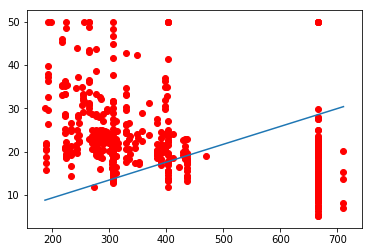

In [23]:
plot_line(x, theta)
plot_dist(x, y)

That's not the line we're looking for.

Let's train for real this time, for 500K epochs with the same settings.

In [24]:
theta = np.random.rand(features, 1)
alpha = 0.00001
epochs = 500000

And use gradient descent.

Loss at Epoch  50000: 100.6240
Loss at Epoch 100000: 91.4668
Loss at Epoch 150000: 83.5487
Loss at Epoch 200000: 76.7018
Loss at Epoch 250000: 70.7813
Loss at Epoch 300000: 65.6619
Loss at Epoch 350000: 61.2351
Loss at Epoch 400000: 57.4073
Loss at Epoch 450000: 54.0974
Loss at Epoch 500000: 51.2353


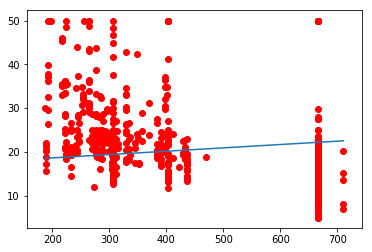

In [25]:
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 50000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

plot_line(x, theta)
plot_dist(x, y)

That's a better line.

Let's train more.

Loss at Epoch  50000: 48.7604
Loss at Epoch 100000: 46.6204
Loss at Epoch 150000: 44.7699
Loss at Epoch 200000: 43.1699
Loss at Epoch 250000: 41.7862
Loss at Epoch 300000: 40.5898
Loss at Epoch 350000: 39.5553
Loss at Epoch 400000: 38.6608
Loss at Epoch 450000: 37.8872
Loss at Epoch 500000: 37.2184


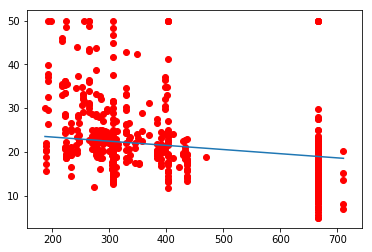

In [26]:
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 50000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

plot_line(x, theta)
plot_dist(x, y)

Getting better! One last 500K.

Loss at Epoch  50000: 36.6400
Loss at Epoch 100000: 36.1399
Loss at Epoch 150000: 35.7074
Loss at Epoch 200000: 35.3335
Loss at Epoch 250000: 35.0101
Loss at Epoch 300000: 34.7305
Loss at Epoch 350000: 34.4888
Loss at Epoch 400000: 34.2797
Loss at Epoch 450000: 34.0989
Loss at Epoch 500000: 33.9426


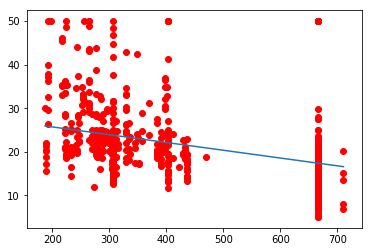

In [27]:
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 50000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

plot_line(x, theta)
plot_dist(x, y)

And now we have a good fitting model for our data.

## Polynomial Linear Regression
In this section, we'll use polynomials of higher degree as our hypothesis function. Since the Boston dataset doesn't have an easily-visible feature that has a higher-degree trend, let's generate our own data.

In [28]:
np.random.seed(422)
x = np.arange(-10, 10) + np.random.normal(-1, 1)
y = x ** 2 + x + np.random.normal(-8, 8, 20)

x = x[..., np.newaxis]
print(x.shape, y.shape)

(20, 1) (20,)


And plot it.

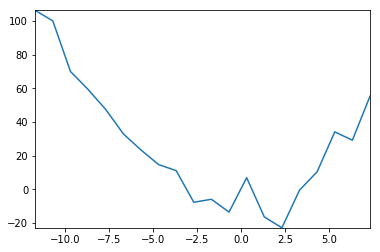

In [29]:
ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)

This time, it makes more sense to use a second-degree hypothesis, specifically of the form:

\begin{align}
h_{\theta}(x) = \theta_01 + \theta_1x + \theta_2x^2 
\end{align}

In machine learning, it is common to denote $\theta_0 = 1$. Do note that we'll still code this up using vector notation, so we'll have to manually add the square and the bias term to our features.

In [30]:
x2 = np.square(x)
bias = np.ones([x.shape[0], 1], dtype=np.int32)
x = np.append(x, x2, axis=1)
x = np.append(x, bias, axis=1)

Our feature matrix now looks like this.

In [31]:
x

array([[-1.16896251e+01,  1.36647335e+02,  1.00000000e+00],
       [-1.06896251e+01,  1.14268085e+02,  1.00000000e+00],
       [-9.68962510e+00,  9.38888345e+01,  1.00000000e+00],
       [-8.68962510e+00,  7.55095844e+01,  1.00000000e+00],
       [-7.68962510e+00,  5.91303342e+01,  1.00000000e+00],
       [-6.68962510e+00,  4.47510840e+01,  1.00000000e+00],
       [-5.68962510e+00,  3.23718338e+01,  1.00000000e+00],
       [-4.68962510e+00,  2.19925836e+01,  1.00000000e+00],
       [-3.68962510e+00,  1.36133334e+01,  1.00000000e+00],
       [-2.68962510e+00,  7.23408317e+00,  1.00000000e+00],
       [-1.68962510e+00,  2.85483297e+00,  1.00000000e+00],
       [-6.89625098e-01,  4.75582776e-01,  1.00000000e+00],
       [ 3.10374902e-01,  9.63325795e-02,  1.00000000e+00],
       [ 1.31037490e+00,  1.71708238e+00,  1.00000000e+00],
       [ 2.31037490e+00,  5.33783219e+00,  1.00000000e+00],
       [ 3.31037490e+00,  1.09585820e+01,  1.00000000e+00],
       [ 4.31037490e+00,  1.85793318e+01

With a shape that we can anticipate.

In [32]:
x.shape

(20, 3)

Let's try out a setup.

In [33]:
features = x.shape[1]
theta = np.random.rand(features, 1)
alpha = 0.00001
epochs = 10000

Plotting the initial guess doesn't give a pretty accurate line.

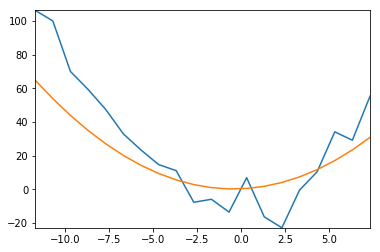

In [34]:
yhat = model(x, theta)

ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)
ax.plot(x[:, 0], yhat)

After 10K epochs:

Loss at Epoch   1000: 52.1626
Loss at Epoch   2000: 51.9445
Loss at Epoch   3000: 51.7433
Loss at Epoch   4000: 51.5539
Loss at Epoch   5000: 51.3729
Loss at Epoch   6000: 51.1981
Loss at Epoch   7000: 51.0280
Loss at Epoch   8000: 50.8614
Loss at Epoch   9000: 50.6977
Loss at Epoch  10000: 50.5364


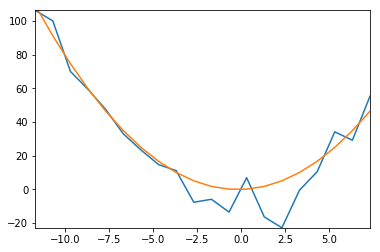

In [35]:
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 1000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)
ax.plot(x[:, 0], yhat)

That's a better line!

Let's see what we get if we train it more.

Loss at Epoch  50000: 44.2406
Loss at Epoch 100000: 40.3591
Loss at Epoch 150000: 37.9647
Loss at Epoch 200000: 36.4876
Loss at Epoch 250000: 35.5765
Loss at Epoch 300000: 35.0144
Loss at Epoch 350000: 34.6677
Loss at Epoch 400000: 34.4538
Loss at Epoch 450000: 34.3219
Loss at Epoch 500000: 34.2405


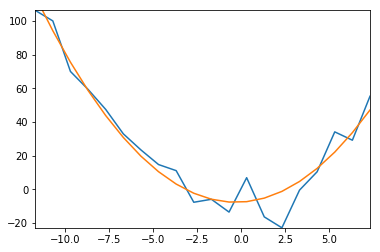

In [36]:
epochs = 500000
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 50000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)
ax.plot(x[:, 0], yhat)

It now captures the trough at the $[-3.0, 1.0]$ range.

Train some more.

Loss at Epoch  50000: 34.1903
Loss at Epoch 100000: 34.1593
Loss at Epoch 150000: 34.1402
Loss at Epoch 200000: 34.1284
Loss at Epoch 250000: 34.1211
Loss at Epoch 300000: 34.1166
Loss at Epoch 350000: 34.1139
Loss at Epoch 400000: 34.1122
Loss at Epoch 450000: 34.1111
Loss at Epoch 500000: 34.1105


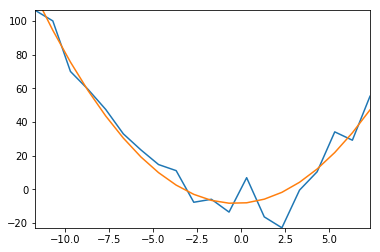

In [37]:
epochs = 500000
for e in range(1, epochs + 1):
    yhat = model(x, theta)
    loss = loss_function(yhat, y)
    theta = gradient_descent(x, y, theta, alpha=alpha)

    if e % 50000 == 0:
        print("Loss at Epoch {:6}: {:.4f}".format(e, loss))

ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)
ax.plot(x[:, 0], yhat)

Looking at the loss, we can see that the model isn't improving anymore. This is a signal that the model has achieved "convergence."

We can (in this case) verify that we have achieved the solution by using the analytical (closed form) solution:

\begin{align}
\theta = (X^Ty)(X^TX)^{-1}
\end{align}


Analytical loss: 34.1105


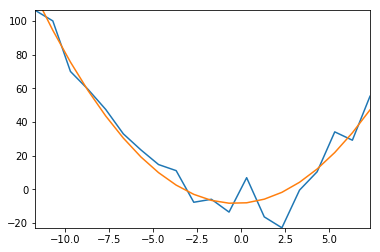

In [38]:
theta_analytical = x.T.dot(y).dot(np.linalg.inv(x.T.dot(x)))[..., np.newaxis]
yhat = model(x, theta)
loss = loss_function(yhat, y)
print("Analytical loss: {:.4f}".format(loss))

ax = plt.axes()
ax.set_xlim(np.min(x[:, 0]), np.max(x[:, 0]))
ax.set_ylim(np.min(y), np.max(y))
ax.plot(x[:, 0], y)
ax.plot(x[:, 0], yhat)

Checking at the two solutions, we can see that the two methods arrive at similar theta parameters.

In [39]:
print(theta)
print(theta_analytical)

[[ 0.60209095]
 [ 0.95523157]
 [-8.26084417]]
[[ 0.60457283]
 [ 0.95626765]
 [-8.32658598]]
